In [1]:
import os
import torch
import torch.nn.functional as F
from omegaconf import OmegaConf, DictConfig
from lamin_dataloader.dataset import GeneIdTokenizer
from contrastive_transformer.data.datamodules import MappedCollectionDataModule
from contrastive_transformer.model import BiEncoderContrastiveModel
import wandb
from tqdm import tqdm
import numpy as np
from pathlib import Path
import argparse
import lightning as L
import pandas as pd
import os
from matplotlib import pyplot as plt

from torch.utils.data import DataLoader
from lamin_dataloader.dataset import InMemoryTokenizedDataset
from lamin_dataloader.dataset import CustomCollate
from lamin_dataloader.dataset import GeneIdTokenizer
import pandas as pd
import scanpy as sc
from ct_rep.utils.utils import get_panel

→ connected lamindb: mojtababahrami/lamindb-storage


/ictstr01/groups/ml01/workspace/mojtaba.bahrami/projects/contrastive-transformer-reproducibility/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 10

In [4]:
entity = "theislab-transformer"
project = "contrastive-transformer"

In [5]:
wandb.login()
api = wandb.Api()

def load_model(run_id, checkpoint):

    run = api.run(f'{entity}/{project}/{run_id}')
    cfg = DictConfig(run.config)

    gpu_info = torch.cuda.get_device_properties(0)
    print(f"GPU Type: {gpu_info.name}")

    # Compatibility changes:
    if 'per_view_normalization' not in cfg.model:
        cfg.model.per_view_normalization = False
    if 'projection_dim' not in cfg.model:
        cfg.model.projection_dim = None
    if 'weight_decay' not in cfg.model.training:
        cfg.model.training.weight_decay = 0.0
    if 'min_lr' not in cfg.model.training:
        cfg.model.training.min_lr = 0.0
    if 'data_loading_speed_sanity_check' not in cfg.model:
        cfg.model.data_loading_speed_sanity_check = False
    if 'decoder_head' not in cfg.model:
        cfg.model.decoder_head = True
    if 'gene_sampling_strategy' in cfg.datamodule.dataset.train:
        cfg.datamodule.gene_sampling_strategy = cfg.datamodule.dataset.train.gene_sampling_strategy
    if 'gene_sampling_strategy' not in cfg.datamodule:
        cfg.datamodule.gene_sampling_strategy = 'random'
    if 'model_speed_sanity_check' not in cfg.datamodule:
        cfg.datamodule.model_speed_sanity_check = False
    if 'min_tokens' not in cfg.model:
        cfg.model.min_tokens = None
    if 'max_tokens' not in cfg.model:
        cfg.model.max_tokens = None
    if 'mask_padding' not in cfg.model:
        cfg.model.mask_padding = False
    if 'flash_attention' not in cfg.model:
        cfg.model.flash_attention = False
    if 'pe_max_len' not in cfg.model:
        cfg.model.pe_max_len = 5000
    if 'loss_switch_step' not in cfg.model:
        cfg.model.loss_switch_step = 2000

    ckpt_path = os.path.join(cfg.PATH.CHECKPOINT_ROOT, run_id, checkpoint)



    gene_mapping = pd.read_pickle(cfg.PATH.gene_mapping_path).to_dict()

    model_args = {
        'config': cfg.model,
        'pad_token_id': gene_mapping['<pad>'],
        'cls_token_id': gene_mapping['<cls>'],
        'vocab_size': len(gene_mapping),
    }
    model = BiEncoderContrastiveModel.load_from_checkpoint(ckpt_path, **model_args)


    model.eval()
    return model, cfg

wandb: Currently logged in as: mojtaba-bahrami to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [71]:
# run_id = "6madwcoy"
# checkpoint = "steps/step=1000000.ckpt"

# neurips_2021_multiome
# run_id = "k7p59riy"
# checkpoint = "steps/step=100000.ckpt"

# run_id = "tszen2pq"
# checkpoint = "steps/step=100000.ckpt"

# # sea-ad
run_id = "meoivn66"
checkpoint = "steps/step=50000.ckpt"

model, cfg = load_model(run_id, checkpoint)

GPU Type: NVIDIA A100 80GB PCIe
####### Using flash_attention encoder implementation !!!!


In [72]:
# dataset_config = ("neurips_2021_multiome", "adata_gex.h5ad", "batch", "s1", "cell_type", "neurips_2021_multiome", "adata_gex.h5ad", "batch", "s3", "cell_type", "blood")
dataset_config = ("sea-ad", "adata_subsample.h5ad", "-", "*", "Subclass", "sea-ad", "adata_merfish_subsample.h5ad", "-", "*", "Subclass", "brain")

dataset_ref, filename_ref, split_key_ref, split_value_ref, label_key_ref, dataset_query, filename_query, split_key_query, split_value_query, label_key_query, tissue = dataset_config

adata_path_ref = f"/lustre/groups/ml01/projects/contrastive_transformer/data/{dataset_ref}/h5ads/{filename_ref}"
adata_train = sc.read_h5ad(adata_path_ref)

In [73]:
batch_size = 64

gene_mapping = pd.read_pickle(cfg.PATH.gene_mapping_path).to_dict()
tokenizer = GeneIdTokenizer(gene_mapping)

collate_fn = CustomCollate(
    tokenizer.PAD_TOKEN, 
    max_tokens = cfg.datamodule.dataset.train.max_tokens,
    gene_sampling_strategy = cfg.datamodule.gene_sampling_strategy
    )

In [74]:
def get_cell_embeddings(adata, features, tokenizer, cfg, model, collate_fn):        
    
    batch_size = 128
    
    test_dataset = InMemoryTokenizedDataset(
        adata[:, features].copy(), 
        tokenizer, 
        normalization=cfg.datamodule.normalization,
        var_column=None)

    # collate_fn = CustomCollate(
    #     tokenizer.PAD_TOKEN, 
    #     max_tokens = cfg.datamodule.dataset.train.max_tokens,
    #     gene_sampling_strategy = cfg.datamodule.gene_sampling_strategy
    #     )

    dataloader = DataLoader(test_dataset, 
                            batch_size = batch_size,
                            collate_fn = collate_fn,
                            shuffle = False,
                            drop_last = False,
                            )

    cell_embs = []
    with torch.no_grad():
        with torch.autocast(device_type=model.device.type, dtype=torch.bfloat16):
            for batch in dataloader:
                batch = {key: value.to(model.device) for key, value in batch.items()}
                output = model.predict_step(batch, 1)
                cell_embs.append(output['cls_cell_emb'].cpu())

    cell_embs = torch.cat(cell_embs, dim=0)
    return cell_embs


In [75]:
panels = {'CosMX 6K': 'CosMX_6K', 
        'CosMX Immuno-Oncology': 'CosMX_IO_100', 
        'CosMX Universal 1K': 'CosMX_Universal_1000', 
        'MERSCOPE Brain 1K': 'MERSCOPE_Human_Brain_1K_Plex', 
        'MERSCOPE PanCancer': 'MERSCOPE_PanCancer_500', 
        'Xenium Brain': 'Xenium_hBrain_v1_metadata', 
        'Xenium Breast': 'Xenium_hBreast_v1_metadata', 
        'Xenium Colon': 'Xenium_hColon_v1_metadata', 
        'Xenium Immuno-Oncology': 'Xenium_hIO_v1_metadata', 
        'Xenium Lung': 'Xenium_hLung_v1_metadata', 
        'Xenium MultiTissue & Cancer': 'Xenium_hMulti_v1_metadata', 
        'Xenium Skin': 'Xenium_hSkin_v1_metadata', 
        'Xenium Prime 5K': 'Xenium_Human_Prime_5K_pan_tissue_pathways_metadata',
        'all_genes': 'all_genes'}

## Compare existing panels

In [32]:
dfs = []

for dataset_name, dataset, filename, run_id, checkpoint in [
    ('Bone marrow', 'neurips_2021_multiome', 'adata_gex.h5ad', 'tszen2pq', 'steps/step=50000.ckpt'), 
    ('Brain (Alzheimer\'s)', 'sea-ad', 'adata_subsample.h5ad', 'meoivn66', 'steps/step=50000.ckpt'), 
    # ('Lung (HLCA)', 'hlca', '9f222629-9e39-47d0-b83f-e08d610c7479_panel_all_subsample_100000.h5ad', '6madwcoy', 'steps/step=1000000.ckpt'),
    # ('Skin', '3f4b7286-d828-4d43-bec5-71898871ebb2', 'adata_subsample.h5ad'),
    # ('skeletal muscle', '7840398e-2e12-49d2-b21a-f59a1908057e', 'adata_subsample.h5ad', 'k5om4aqx', 'steps/step=50000.ckpt'),
    # ('Lung', 'a9dd3a9d-ef9f-49bb-b97b-e435817fc890', 'adata_subsample.h5ad', 'l43bx1dl', 'steps/step=50000.ckpt'),
    ('Ovarian cancer', '10x_scRNA_ovarian_cancer', 'adata.h5ad', 'j2rbbon6', 'steps/step=50000.ckpt')
    ]:
    model, cfg = load_model(run_id, checkpoint)
    
    gene_mapping = pd.read_pickle(cfg.PATH.gene_mapping_path).to_dict()
    tokenizer = GeneIdTokenizer(gene_mapping)

    collate_fn = CustomCollate(
        tokenizer.PAD_TOKEN, 
        max_tokens = cfg.datamodule.dataset.train.max_tokens,
        gene_sampling_strategy = cfg.datamodule.gene_sampling_strategy
        )

    adata_train = sc.read_h5ad(f"/lustre/groups/ml01/projects/contrastive_transformer/data/{dataset}/h5ads/{filename}")
    
    batch_size = 4096
    rng = np.random.default_rng(seed=42)
    random_indices = rng.choice(adata_train.n_obs, batch_size, replace=False)
    adata_subset = adata_train[random_indices].copy()

    features_1 = adata_subset.var_names.values.astype(str)
    cell_embs_1 = get_cell_embeddings(adata_subset, features_1, tokenizer, cfg, model, collate_fn)

    mutual_infos = []


    for panel_name, panel_filename in tqdm(panels.items()):
        if panel_name == 'all_genes':
            panel = adata_subset.var_names.values.astype(str)
        else:
            panel = get_panel(panel_filename)
        features_2 = np.intersect1d(adata_subset.var_names.values, panel)
        cell_embs_2 = get_cell_embeddings(adata_subset, features_2, tokenizer, cfg, model, collate_fn)

        cell_embs_norm_1 = F.normalize(cell_embs_1, p=2, dim=1)
        cell_embs_norm_2 = F.normalize(cell_embs_2, p=2, dim=1)

        logits = torch.mm(cell_embs_norm_1, cell_embs_norm_2.t()) * model.logit_scale.exp().to('cpu')
        prob = logits.softmax(dim=1)

        cont_target = torch.arange(len(logits), device=logits.device)
        loss_cont = F.cross_entropy(logits, cont_target)

        mutual_info = float(np.log(len(logits)) - loss_cont.item())
        mutual_infos.append((dataset_name, panel_name, mutual_info, len(panel), len(features_2)))
        
    df = pd.DataFrame(mutual_infos, columns=['dataset', 'panel_name', 'mutual_info', 'panel_size', 'features_size'])
    df['mutual_info_norm'] = df['mutual_info'] / df['mutual_info'].max()
    dfs.append(df)

GPU Type: NVIDIA A100 80GB PCIe
####### Using flash_attention encoder implementation !!!!


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:20<00:00,  1.44s/it]


GPU Type: NVIDIA A100 80GB PCIe
####### Using flash_attention encoder implementation !!!!


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:25<00:00,  1.81s/it]


GPU Type: NVIDIA A100 80GB PCIe
####### Using flash_attention encoder implementation !!!!


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:17<00:00,  1.23s/it]


In [33]:
df = pd.concat(dfs)
# df = df[df.panel_name != 'all_genes']

In [34]:
df.sort_values(by='features_size', ascending=False, inplace=True)

In [35]:
df = df[df['panel_size'] <2000]

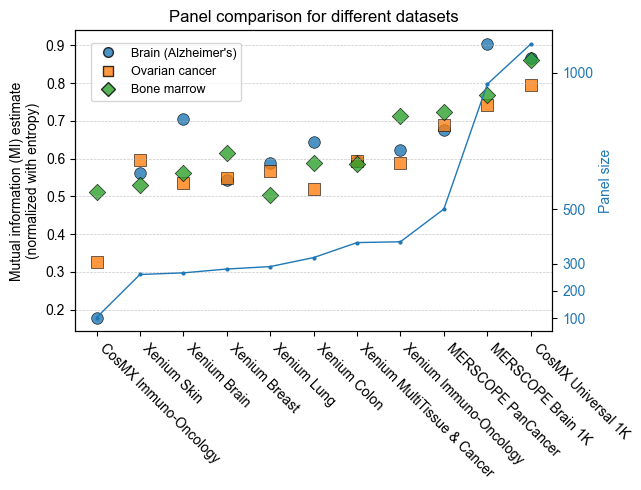

In [36]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(6.5, 5))

import itertools
colors = plt.cm.tab10.colors  # Up to 20 unique colors
import random
# colors = list(colors)
# random.shuffle(colors, random.seed(42))
color_cycle = itertools.cycle(colors)
# Assign a unique color to each dataset
datasets = df['dataset'].unique()
dataset_colors = {ds: next(color_cycle) for ds in datasets}

# Assign a unique marker to each dataset (keep shapes for each dataset)
marker_list = ['o', 's', 'D', '^', 'v', '<', '>', 'P', 'X', '*', 'h', 'H', 'd', 'p', '|', '_', '+', 'x', '1', '2']
marker_cycle = itertools.cycle(marker_list)
dataset_markers = {ds: next(marker_cycle) for ds in datasets}

# Store handles for custom legends
dataset_handles = {}

# Get unique panel names (excluding 'all_genes') and sort by panel_size for consistent x-axis
panel_names = [p for p in df['panel_name'].unique() if p != 'all_genes']

# Compute mean panel_size for each panel_name
panel_size_map = df[df['panel_name'] != 'all_genes'].groupby('panel_name')['panel_size'].mean().to_dict()
panel_names_sorted = sorted(panel_names, key=lambda p: panel_size_map.get(p, 0))
x_pos = {panel: i for i, panel in enumerate(panel_names_sorted)}

# Plot each point with its color (dataset) and marker (dataset)
marker_alpha = 0.8  # Set transparency for each marker
for i, row in df[df['panel_name'] != 'all_genes'].iterrows():
    h = ax1.scatter(
        x_pos[row['panel_name']],
        row['mutual_info_norm'],
        marker=dataset_markers[row['dataset']],
        color=dataset_colors[row['dataset']],
        label=row['dataset'],
        edgecolor='k',
        linewidth=0.5,
        alpha=marker_alpha,
        s=70
    )
    # For dataset legend (color+marker)
    if row['dataset'] not in dataset_handles:
        dataset_handles[row['dataset']] = plt.Line2D(
            [], [], marker=dataset_markers[row['dataset']], color=dataset_colors[row['dataset']], linestyle='None',
            markersize=7, label=row['dataset'], markerfacecolor=dataset_colors[row['dataset']], markeredgecolor='k', alpha=marker_alpha
        )

# Add a horizontal line for the mutual information of 'all_genes'
if 'all_genes' in [x[0] for x in mutual_infos]:
    # Find the mutual_info for 'all_genes'
    all_genes_mi = None
    for tup in mutual_infos:
        if tup[0] == 'all_genes':
            all_genes_mi = tup[1]
            break
    if all_genes_mi is not None:
        ax1.axhline(
            y=all_genes_mi,
            color='black',
            linestyle='--',
            linewidth=1.5,
            label='all_genes'
        )

# ax1.set_xlabel('Panel name')
ax1.set_ylabel('Mutual information (MI) estimate\n(normalized with entropy)')
ax1.set_title('Panel comparison for different datasets')

# Set x-ticks as discrete panel names
ax1.set_xticks(list(x_pos.values()))
ax1.set_xticklabels(list(x_pos.keys()), rotation=-45, ha='left', fontsize=10)

ax1.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5, alpha=0.7)
# Dataset legend (color+marker)
dataset_legend = ax1.legend(
    dataset_handles.values(),
    dataset_handles.keys(),
    bbox_to_anchor=(0.02, 0.98),
    loc='upper left',
    fontsize=9,
    # title="Dataset (color/marker)"
)

# Plot panel_size as a line plot on a secondary y-axis (log y-axis)
ax2 = ax1.twinx()
panel_sizes = [panel_size_map[p] for p in panel_names_sorted]
ax2.plot(list(x_pos.values()), panel_sizes, color='tab:blue', marker='o', linestyle='-', linewidth=1, label='Panel size', markersize=2)
ax2.set_ylabel('Panel size', color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:blue')
# ax2.set_yscale('log')
# Set y-ticks and y-tick labels safely for log scale
yticks = [100, 200, 300, 500, 1000]
ax2.set_yticks(yticks)
ax2.set_yticklabels([str(y) for y in yticks])

plt.tight_layout()

os.makedirs(f'ct_rep/panel_design/figures/', exist_ok=True)
plt.savefig(f'ct_rep/panel_design/figures/current_panels.pdf', bbox_inches='tight')

## Effect of batch size

In [64]:
import time
mutual_infos = []
for batch_size in tqdm([32, 64, 128, 256, 512, 1024, 1024*2, 1024*4, 1024*8]):
    
    rng = np.random.default_rng(seed=42)
    random_indices = rng.choice(adata_train.n_obs, batch_size, replace=False)
    adata_subset = adata_train[random_indices].copy()
    
    start_time = time.time()
    features_1 = adata_subset.var_names.values.astype(str)
    cell_embs_1 = get_cell_embeddings(adata_subset, features_1, tokenizer, cfg, model, collate_fn)
    
    panel_name = 'Xenium Immuno-Oncology'
    panel = get_panel(panels[panel_name])
    features_2 = np.intersect1d(adata_subset.var_names.values, panel)
    cell_embs_2 = get_cell_embeddings(adata_subset, features_2, tokenizer, cfg, model, collate_fn)

    cell_embs_norm_1 = F.normalize(cell_embs_1, p=2, dim=1)
    cell_embs_norm_2 = F.normalize(cell_embs_2, p=2, dim=1)

    logits = torch.mm(cell_embs_norm_1, cell_embs_norm_2.t()) * model.logit_scale.exp().to('cpu')
    prob = logits.softmax(dim=1)

    cont_target = torch.arange(len(logits), device=logits.device)
    loss_cont = F.cross_entropy(logits, cont_target)

    mutual_info = float(np.log(len(logits)) - loss_cont.item())
    end_time = time.time()
    mutual_infos.append((panel_name, mutual_info, len(panel), len(features_2), batch_size, end_time - start_time))
    
df = pd.DataFrame(mutual_infos, columns=['panel_name', 'mutual_info', 'panel_size', 'features_size', 'batch_size', 'time'])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:18<00:00,  2.10s/it]


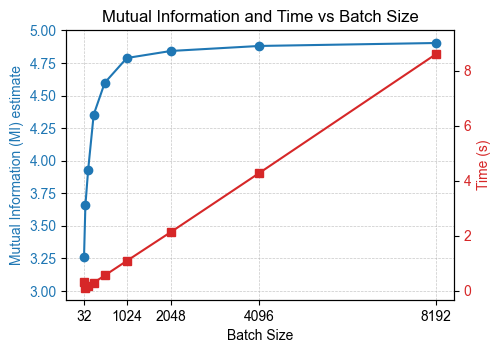

In [70]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(5, 3.5))

color1 = 'tab:blue'
ax1.set_xlabel('Batch Size')
ax1.set_ylabel('Mutual Information (MI) estimate', color=color1)
ax1.plot(df['batch_size'], df['mutual_info'], marker='o', color=color1)
ax1.tick_params(axis='y', labelcolor=color1)
ax1.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5, alpha=0.7)
ax1.set_xticks([32, 1024, 2048, 4096, 8192])
ax1.set_xticklabels([32, 1024, 2048, 4096, 8192])
ax1.set_ylim(min(df['mutual_info'])*0.9, max(df['mutual_info'])*1.02)  # Set the max on the right y axis to 8
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color2 = 'tab:red'
ax2.set_ylabel('Time (s)', color=color2)
ax2.plot(df['batch_size'], df['time'], marker='s', color=color2)
ax2.tick_params(axis='y', labelcolor=color2)
ax2.set_ylim(top=max(df['time'])*1.1)  # Set the max on the right y axis to 8

plt.title('Mutual Information and Time vs Batch Size')

plt.savefig(f'ct_rep/panel_design/figures/{dataset_ref}/mutual_info_and_time_vs_batch_size.pdf', bbox_inches='tight')

## Best next gene to add

In [149]:
batch_size = 2048
rng = np.random.default_rng(seed=42)
random_indices = rng.choice(adata_train.n_obs, batch_size, replace=False)
adata_subset = adata_train[random_indices].copy()

In [291]:
features_1 = adata_subset.var_names.values.astype(str)
cell_embs_1 = get_cell_embeddings(adata_subset, features_1, tokenizer, cfg, model, collate_fn)

start_panel_name = 'Xenium Brain'
max_panel_name = 'MERSCOPE Brain 1K'
start_panel = get_panel(panels[start_panel_name])
max_panel = get_panel(panels[max_panel_name])
mutual_infos = []

for gene in tqdm(np.setdiff1d(max_panel, start_panel)):
    panel = np.concatenate([start_panel, [gene]])
    
    features_2 = np.intersect1d(adata_subset.var_names.values, panel)
    cell_embs_2 = get_cell_embeddings(adata_subset, features_2, tokenizer, cfg, model, collate_fn)

    cell_embs_norm_1 = F.normalize(cell_embs_1, p=2, dim=1)
    cell_embs_norm_2 = F.normalize(cell_embs_2, p=2, dim=1)

    logits = torch.mm(cell_embs_norm_1, cell_embs_norm_2.t()) * model.logit_scale.exp().to('cpu')
    # prob = logits.softmax(dim=1)

    cont_target = torch.arange(len(logits), device=logits.device)
    loss_cont = F.cross_entropy(logits, cont_target)

    mutual_info = float(np.log(len(logits)) - loss_cont.item())
    mutual_infos.append((gene, mutual_info))


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 850/850 [11:43<00:00,  1.21it/s]


In [150]:
import pickle
# with open(f'ct_rep/panel_design/mutual_infos_[{start_panel_name}]_[{max_panel_name}].pkl', 'wb') as f:
#     pickle.dump(mutual_infos, f)
    
# start_panel_name = 'Xenium_hIO'
# max_panel_name = 'CosMX_6K'

start_panel_name = 'Xenium Brain'
max_panel_name = 'MERSCOPE Brain 1K'

start_panel = get_panel(panels[start_panel_name])
max_panel = get_panel(panels[max_panel_name])
mutual_infos = pickle.load(open(f'ct_rep/panel_design/mutual_infos_[{start_panel_name}]_[{max_panel_name}].pkl', 'rb'))

In [151]:
df = pd.DataFrame(mutual_infos, columns=['gene', 'mutual_info'])
df['available'] = df.gene.apply(lambda x: x in adata_subset.var_names)
df = df[df['available'] == True]
df = df.sort_values(by='mutual_info', ascending=False)
df['rank'] = np.arange(len(df))

# df = df[df['mutual_info'] > df['mutual_info'].median()].copy()
df = df[df['rank'] < int(0.8 * len(df))].copy()

In [152]:
df

,gene,mutual_info,available,rank
259,ENSG00000117020,5.454725,True,0
479,ENSG00000151150,5.426996,True,1
349,ENSG00000135541,5.419867,True,2
270,ENSG00000118473,5.417171,True,3
478,ENSG00000151067,5.415084,True,4
...,...,...,...,...
28,ENSG00000017427,5.308406,True,671
111,ENSG00000079337,5.308391,True,672
762,ENSG00000187398,5.308326,True,673
220,ENSG00000111907,5.308233,True,674


In [153]:
# adata_subset = adata_train.copy()
adata_subset

AnnData object with n_obs × n_vars = 2048 × 36412
    obs: 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'is_primary_data', 'Neurotypical reference', 'Class', 'Subclass', 'Supertype', 'Age at death', 'Years of education', 'Cognitive status', 'ADNC', 'Braak stage', 'Thal phase', 'CERAD score', 'APOE4 status', 'Lewy body disease pathology', 'LATE-NC stage', 'Microinfarct pathology', 'Specimen ID', 'donor_id', 'PMI', 'Number of UMIs', 'Genes detected', 'Fraction mitochrondrial UMIs', 'suspension_type', 'development_stage_ontology_term_id', 'Continuous Pseudo-progression Score', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length', 'fea

In [154]:
from ct_rep.utils.utils import get_hvgs
adata_subset_subset = adata_subset[:, adata_subset.var_names.isin(np.setdiff1d(max_panel, start_panel))].copy()
flavor = 'seurat_v3'
# flavor = 'cell_ranger'
HVGs = get_hvgs(adata_subset_subset, n_top_genes=20, flavor=flavor)

df['HVG'] = df.gene.apply(lambda x: x in HVGs)

using raw data for flavor seurat_v3


In [155]:
import scanpy as sc
from ct_rep.utils.utils import normalize

del adata_subset.raw
adata_subset.layers['normalized'] = normalize(adata_subset.X.toarray(), 'totalcount_log1p')

adata_subset_subset = adata_subset[:, adata_subset.var_names.isin(np.setdiff1d(max_panel, start_panel))].copy()

# Calculate differentially expressed genes (DEGs) between cell types
# You may want to change 'cell_type' to another obs column if needed
sc.tl.rank_genes_groups(adata_subset_subset, groupby='cell_type', layer='normalized', method='wilcoxon', n_genes=adata_subset_subset.shape[1])

top_k = 1
degs = set()
for group in adata_subset_subset.obs['cell_type'].unique():
    # Get the top 5 gene names for this group (as strings)
    top_genes = adata_subset_subset.uns['rank_genes_groups']['names'][group][:top_k]
    # Ensure top_genes is a list/array of gene names (strings), not used as indexers
    degs.update(top_genes)
    
df['DEG'] = df.gene.apply(lambda x: x in degs)


In [156]:
df['type'] = df.apply(lambda row: 'DEG' if row['DEG'] else ('HVG' if row['HVG'] else 'other'), axis=1)

In [157]:
len(degs)

18

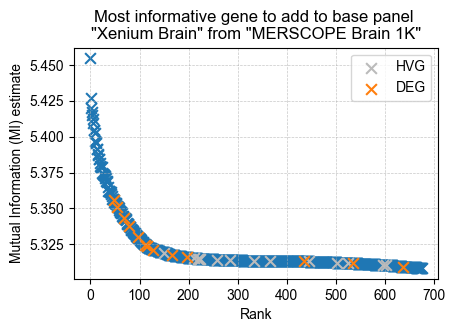

In [158]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4.7, 3))

# Plot "other" (neither HVG nor DEG) first, then HVG, then DEG on top
other_true = df[(df['HVG'] == False) & (df['DEG'] == False)]
plt.scatter(other_true['rank'], other_true['mutual_info'], marker='x', c='tab:blue', s=60)  # no label

hvg_true = df[(df['HVG'] == True) & (df['DEG'] == False)]
plt.scatter(hvg_true['rank'], hvg_true['mutual_info'], marker='x', c='#bbbbbb', label='HVG', s=60)

deg_true = df[df['DEG'] == True]
plt.scatter(deg_true['rank'], deg_true['mutual_info'], marker='x', c='tab:orange', label='DEG', s=60)

plt.xlabel('Rank')
plt.ylabel('Mutual Information (MI) estimate')
plt.title(f'Most informative gene to add to base panel \n"{start_panel_name}" from "{max_panel_name}"')
plt.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5, alpha=0.7)

plt.legend()

plt.savefig(f'ct_rep/panel_design/figures/{dataset_ref}/mi_gain_per_gene.pdf', bbox_inches='tight')

In [159]:
from ct_rep.utils.utils import gene_id_to_name
df['gene_name'] = df['gene'].map(gene_id_to_name)

In [164]:
df['mean_expression'] = adata_train[:, df['gene']].X.mean(axis=0).A.squeeze()
df['median_expression'] = np.median(adata_train[:, df['gene']].X.toarray(), axis=0)
df['expression_std'] = np.std(adata_train[:, df['gene']].X.toarray(), axis=0)
df['expression_std_normalized'] = np.std(adata_train[:, df['gene']].X.toarray(), axis=0) / df['mean_expression']
df['nnz'] = (adata_train[:, df['gene']].X>0).sum(axis=0).A.squeeze()
df['nnz_ratio'] = df['nnz'] / adata_train.shape[0]

In [163]:
df[:200]

,gene,mutual_info,available,rank,HVG,DEG,type,gene_name,mean_expression,median_expression,expression_std,expression_std_normalized,nnz,nnz_ratio
259,ENSG00000117020,5.454725,True,0,False,False,other,AKT3,18.472168,12.0,20.742966,1.122931,1998,0.975586
479,ENSG00000151150,5.426996,True,1,False,False,other,ANK3,29.389648,20.0,32.259613,1.097652,1942,0.948242
349,ENSG00000135541,5.419867,True,2,False,False,other,AHI1,13.498047,9.0,14.769989,1.094232,1923,0.938965
270,ENSG00000118473,5.417171,True,3,False,False,other,SGIP1,9.591797,7.0,10.278113,1.071552,1892,0.923828
478,ENSG00000151067,5.415084,True,4,False,False,other,CACNA1C,26.630371,17.0,32.588898,1.223749,1848,0.902344
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
517,ENSG00000157483,5.315963,True,195,False,False,other,MYO1E,0.527832,0.0,1.739721,3.295975,410,0.200195
734,ENSG00000184985,5.315935,True,196,False,True,DEG,SORCS2,1.670410,0.0,3.214543,1.924403,1005,0.490723
728,ENSG00000184371,5.315905,True,197,False,False,other,CSF1,0.043945,0.0,0.251988,5.734121,72,0.035156
81,ENSG00000070018,5.315739,True,198,False,False,other,LRP6,1.739746,1.0,2.297691,1.320705,1358,0.663086


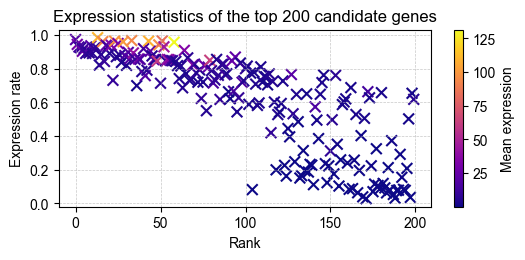

In [166]:
plt.figure(figsize=(6, 2.3))

# Plot "other" (neither HVG nor DEG) first, then HVG, then DEG on top
top_k = 200
df_subset = df[:top_k]
plt.scatter(df_subset['rank'], df_subset['nnz_ratio'], marker='x', c=df_subset['mean_expression'], cmap='plasma', s=60)  # color by mean expression
plt.xlabel('Rank')
plt.ylabel('Expression rate')
plt.title(f'Expression statistics of the top {top_k} candidate genes')
plt.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.colorbar(label='Mean expression')
plt.savefig(f'ct_rep/panel_design/figures/{dataset_ref}/expression_statistics_of_top_candidates.pdf', bbox_inches='tight')

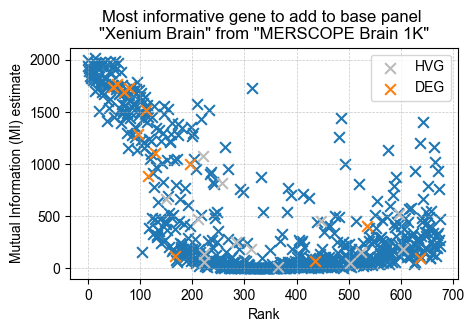

In [35]:
plt.figure(figsize=(5, 3))

# Plot "other" (neither HVG nor DEG) first, then HVG, then DEG on top
other_true = df[(df['HVG'] == False) & (df['DEG'] == False)]
plt.scatter(other_true['rank'], other_true['nnz'], marker='x', c='tab:blue', s=60)  # no label

hvg_true = df[(df['HVG'] == True) & (df['DEG'] == False)]
plt.scatter(hvg_true['rank'], hvg_true['nnz'], marker='x', c='#bbbbbb', label='HVG', s=60)

deg_true = df[df['DEG'] == True]
plt.scatter(deg_true['rank'], deg_true['nnz'], marker='x', c='tab:orange', label='DEG', s=60)

plt.xlabel('Rank')
plt.ylabel('Mutual Information (MI) estimate')
plt.title(f'Most informative gene to add to base panel \n"{start_panel_name}" from "{max_panel_name}"')
plt.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5, alpha=0.7)

plt.legend()

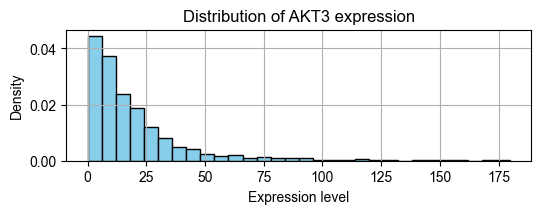

In [415]:
import matplotlib.pyplot as plt

gene = 'ENSG00000117020'
gene_name = gene_id_to_name[gene]
gene_expr = adata_subset[:, [gene]].X.toarray().flatten()
plt.figure(figsize=(6, 1.7))
plt.hist(gene_expr, bins=30, color='skyblue', edgecolor='black', density=True)
plt.xlabel('Expression level')
plt.ylabel('Density')
plt.title(f'Distribution of {gene_name} expression')
plt.grid(True)
plt.savefig(f'ct_rep/panel_design/figures/{dataset_ref}/gene_expr_distribution_{gene_name}.pdf', bbox_inches='tight')